In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cuisine-rating/Cuisine_rating.csv


In [10]:
df = pd.read_csv("/kaggle/input/cuisine-rating/Cuisine_rating.csv")
df.head()

,User ID,Area code,Location,Gender,YOB,Marital Status,Activity,Budget,Cuisines,Alcohol,Smoker,Food Rating,Service Rating,Overall Rating,Often A S
0,1,153,"Upper East Side,NY",Female,2006,Single,Professional,3,Japanese,Never,Never,5,4,4.5,No
1,2,123,"St. George,NY",Female,1991,Married,Student,3,Indian,Never,Socially,1,1,1.0,No
2,3,122,"Upper West Side,NY",Male,1977,Single,Student,5,Seafood,Often,Often,5,5,5.0,Yes
3,4,153,"Upper East Side,NY",Female,1956,Married,Professional,5,Japanese,Never,Socially,3,1,2.0,No
4,5,129,"Central Park,NY",Male,1997,Single,Student,4,Filipino,Socially,Never,2,4,3.0,No


# Overall Rating -- Location & Gender

Create a bar plot to investigate the average rating in each location, and to see whether male and female beahve different across locations.
The x-tick shows the location, and each location above has three bars, 'total', 'male', 'female' average rating.

Since the location are all in NewYork, I just drop the city name behind the comma. (There are also 'Central Park,ny/NY', 'Market City, MY/NY' in the data set and I suspect that they are the same place.)

Using groupby method, the mean of the overall rating can be obtained.

In [11]:
#Modify the location column.
df["Location"] = df["Location"].str.split(",", expand=True)[0]

#Calculate the overall rating average regarless of the gender.
tot_overall = df.groupby(["Location"]).mean()[["Overall Rating"]]
tot_overall

,Overall Rating
Location,
Cedar Hill,3.500000
Central Park,3.500000
China Town,3.159091
Market City,3.659091
Riverdale,3.053571
St. George,3.119565
Upper East Side,3.016667
Upper West Side,3.138889


Then, we create a new dataframe, called **df_bar**, to store all these information that could help us draw the final bar plot. Using pivot_table to rotate the original dataframe and then join (not merge!) in the tot_overall data frame.

                   Female      Male  Overall Rating
Location                                           
Cedar Hill            NaN  3.500000        3.500000
Central Park     3.900000  3.318182        3.500000
China Town       3.250000  3.138889        3.159091
Market City      3.625000  3.678571        3.659091
Riverdale        3.428571  2.678571        3.053571
St. George       3.194444  3.071429        3.119565
Upper East Side  3.000000  3.041667        3.016667
Upper West Side  3.300000  2.937500        3.138889


<AxesSubplot:title={'center':'Overall Rating in New York'}, xlabel='locations', ylabel='Mean Rating'>

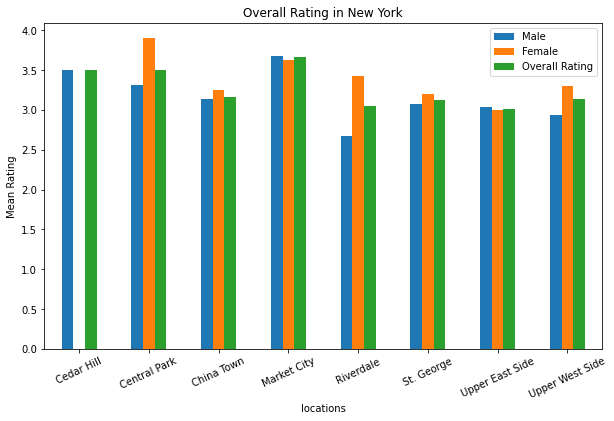

In [12]:
df_bar = pd.pivot_table(df, values="Overall Rating", index="Location", columns=["Gender"])
df_bar = df_bar.join(tot_overall)
print(df_bar)
df_bar.plot.bar(y=["Male", "Female", "Overall Rating"], rot=25, figsize=(10,6), title="Overall Rating in New York", xlabel="locations", ylabel="Mean Rating")

From the bar chart, we could see that except in 'Cedar Hill', 'Market City', and 'Upper East Side', Female customers tend to give higher rating to the restaurants than Male customers. Besides, in 'Market City', and 'Upper East Side', the rating between two genders are almost the same.

The highest and lowest rating locations are summarized in the following table.

|        | Highest      | Lowest          |
|--------|--------------|-----------------|
| Female | Central Park (3.9) | Upper East Side (3.0) |
| Male   | Market City (3.7)  | Riverdale     (2.7)  |
| Total  | Market City (3.7) | Upper East Side (3.0)|

We could further ask that in a given location, which type of cuisine scores the highest?

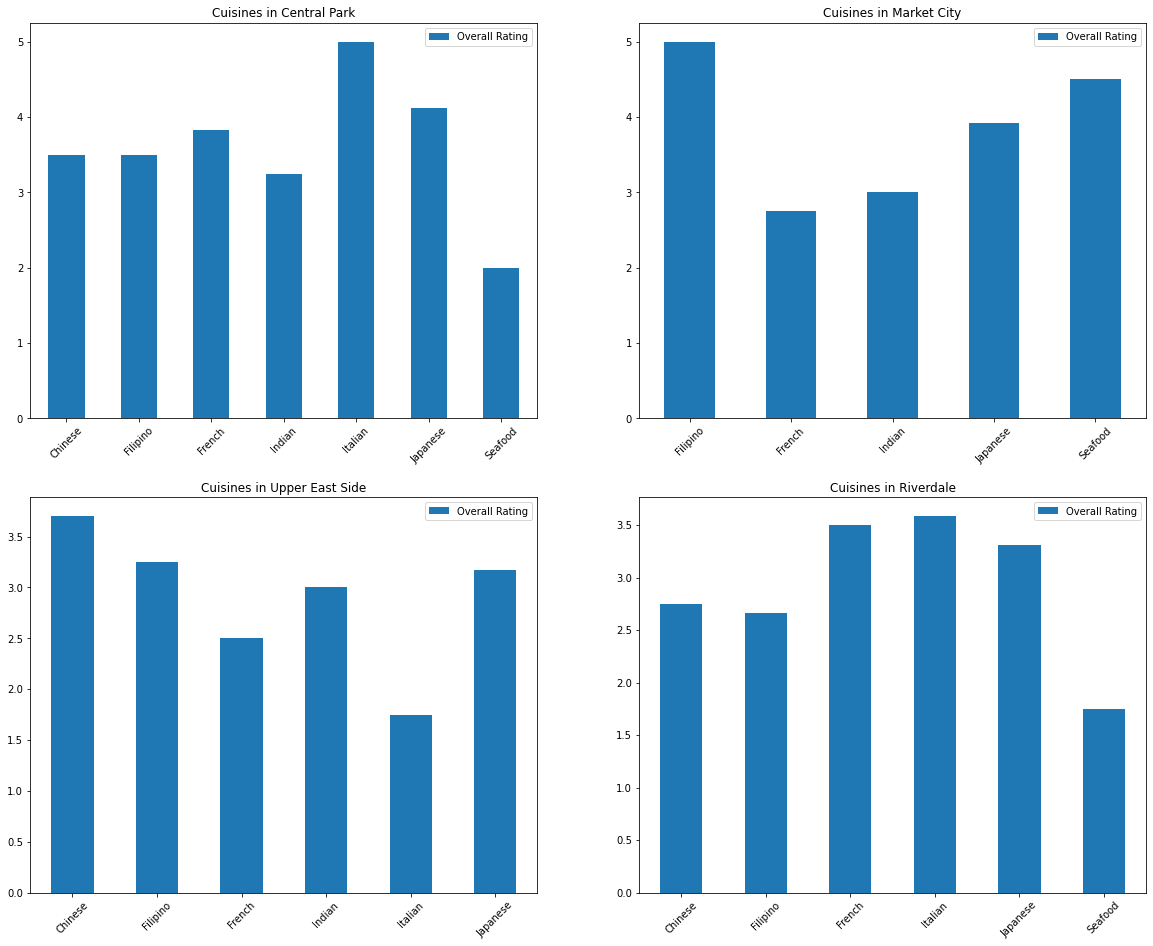

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,16))
def fav_type(location):
    dftmp = df[df["Location"] == location]
    return pd.pivot_table(dftmp, index="Cuisines", values="Overall Rating")

def plot_fav(location, I):
    fav_type(location).plot.bar(rot = 45, title = "Cuisines in " + location, ax=axes[I], xlabel="")

plot_fav("Central Park", (0,0))
plot_fav("Market City", (0,1))
plot_fav("Upper East Side", (1,0))
plot_fav("Riverdale", (1,1))


# Comparison of services & preference rating

Surprisingly, the service rating is barely correlated to the food rating. That is, one could hardly tell the service rating acccording to the food rating one has rated, and vice versa.

In [14]:
dfRate = df[["Food Rating","Service Rating", "Overall Rating"]]
dfRate.corr()

,Food Rating,Service Rating,Overall Rating
Food Rating,1.000000,0.079056,0.709562
Service Rating,0.079056,1.000000,0.758532
Overall Rating,0.709562,0.758532,1.000000


<AxesSubplot:xlabel='Food Rating', ylabel='Overall Rating'>

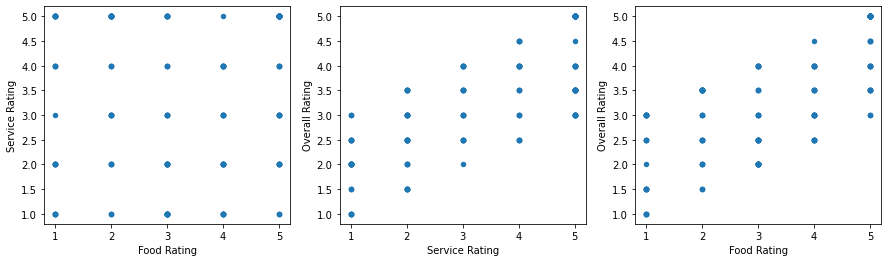

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
dfRate.plot.scatter(x="Food Rating", y="Service Rating", ax=axes[0])
dfRate.plot.scatter(x="Service Rating", y="Overall Rating", ax=axes[1])
dfRate.plot.scatter(x="Food Rating", y="Overall Rating", ax=axes[2])

From the scatter plot above, service and food ratings have scattered uniformly hence give no information to the other variable; whereas the positive trend with the overall rating for service and food rating is pretty clear in the second and the third plot.

#  Visualizing from each feature.

Finally, I present a bar chart to investigate the overall rating from all the aspects of the data.

<AxesSubplot:xlabel='Location'>

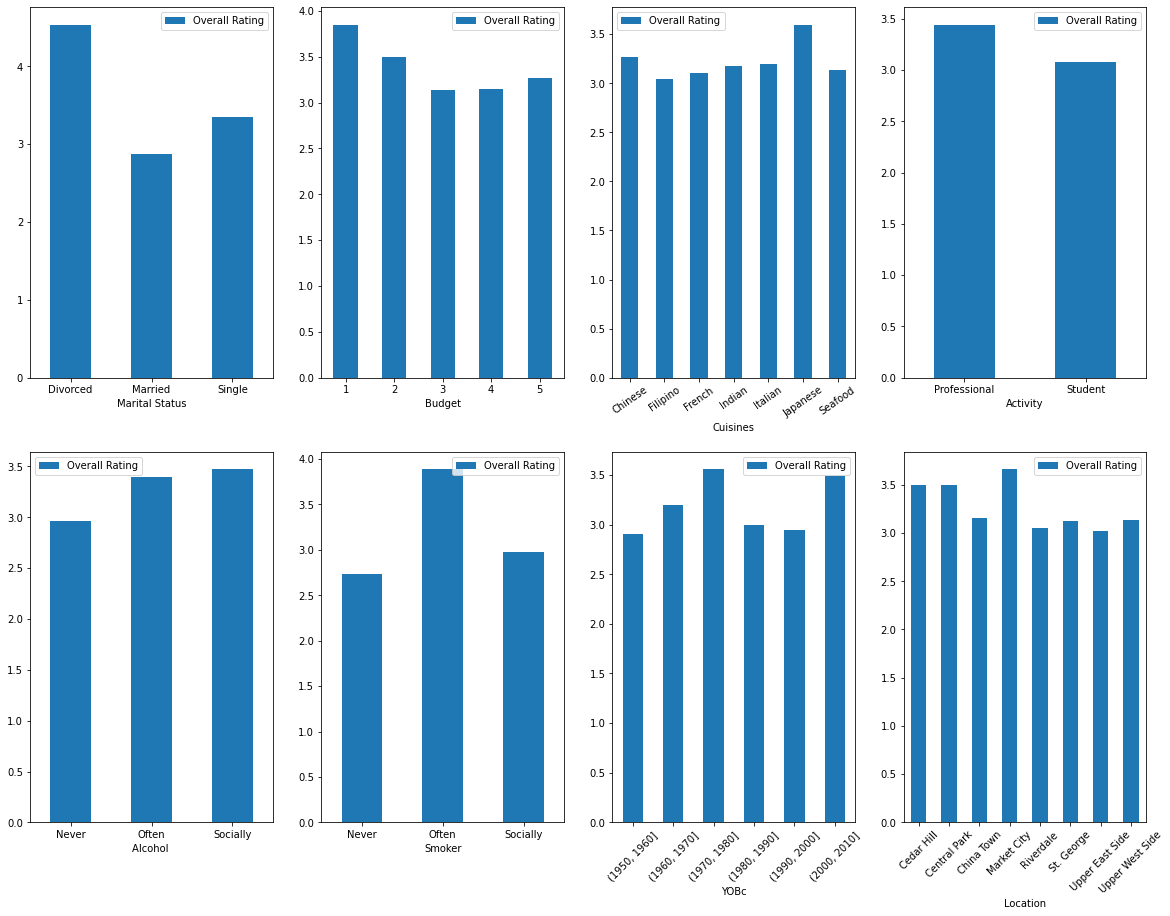

In [16]:
# Make intervals according to their YOB
Year = np.arange(1950, 2020, 10)
df["YOBc"] = pd.cut(df["YOB"],Year)


def different_aspect(col):
    return pd.pivot_table(df, index=col, values="Overall Rating")

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,15))
different_aspect("Marital Status").plot.bar(rot=0, ax=axes[0,0])
different_aspect("Budget").plot.bar(rot=0, ax=axes[0,1])
different_aspect("Cuisines").plot.bar(rot=35, ax=axes[0,2])
different_aspect("Activity").plot.bar(rot=0, ax=axes[0,3])
different_aspect("Alcohol ").plot.bar(rot=0, ax=axes[1,0])
different_aspect("Smoker").plot.bar(rot=0, ax=axes[1,1])
different_aspect("YOBc").plot.bar(rot=45, ax=axes[1,2])
different_aspect("Location").plot.bar(rot=45, ax=axes[1,3])